<a href="https://colab.research.google.com/github/adamd1985/Lectures_On_MLAI/blob/main/4_3_Gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Gradient Descent

## Introduction

Gradient Descent in its simplest form, follows the update rule:

$ \beta^{(t+1)} = \beta^{(t)} - \eta \nabla J(\beta) $

where:
- $ \beta $ represents the model parameters,
- $ \eta $ is the learning rate, which controls the step size,
- $ J(\beta) $ is the cost function to minimize,
- $ \nabla J(\beta) $ is the gradient of the cost function with respect to $ \beta $.

This notebook will cover key concepts of machine learning, focusing on linear and logistic regression, and demonstrate how gradient descent is used to train these models. We will explore the mathematics behind these algorithms and apply them in Python.

Our goal is to find the lowest point of this function using gradient descent. This is exactly what we do in machine learning, where the function is usually a measure of error. We will do one error mimization at the end of the notebook.


In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

##  Convexity

A function $ f(x) $ is **convex** if, for any two points $ x_1, x_2 $ in its domain and for any $ \lambda \in [0,1] $, the following condition holds:

$ f(\lambda x_1 + (1 - \lambda)x_2) \leq \lambda f(x_1) + (1 - \lambda) f(x_2) $

### First and Second Derivative Conditions for Convexity

A differentiable function $ f(x) $ is convex if its **first derivative** satisfies:

$ f'(x_2) \geq f'(x_1) $ for all $ x_2 > x_1 $

This implies that the function's slope does not decrease as $ x $ increases.

A twice-differentiable function $ f(x) $ is convex if its **second derivative** is non-negative:

$ f''(x) \geq 0 $ for all $ x $ in the domain.

This means the function curves upwards everywhere, which ensures that gradient descent can efficiently find the global minimum.


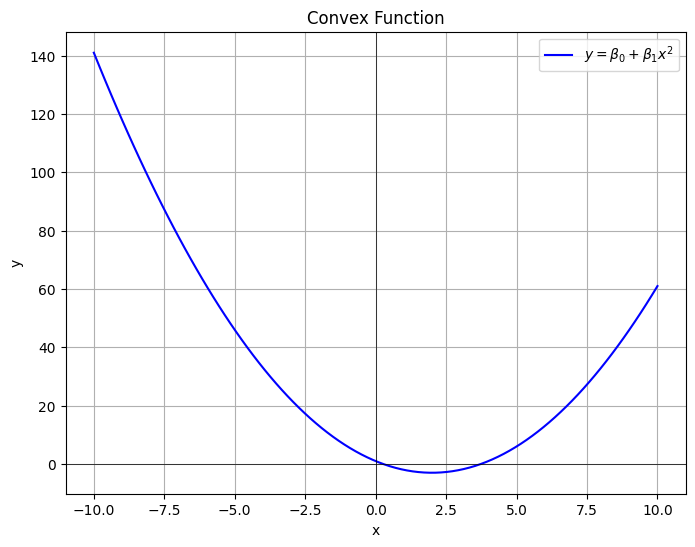

In [363]:
def quadratic_func(x):
    return x**2 - 4*x + 1, 2*x - 4

x_values = np.linspace(-10, 10, 100)
y_values, _ = quadratic_func(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=r'$y = \beta_0 + \beta_1 x^2$', color='b')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Convex Function')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()
plt.grid()

plt.show()

## Differentiability


A function $ f(x) $ is **differentiable** at a point $ x $ if its derivative $ f'(x) $ exists, meaning:

$ \lim_{h \to 0} \frac{f(x + h) - f(x)}{h} $ exists.

This means the function has a **well-defined slope** at every point in its domain.


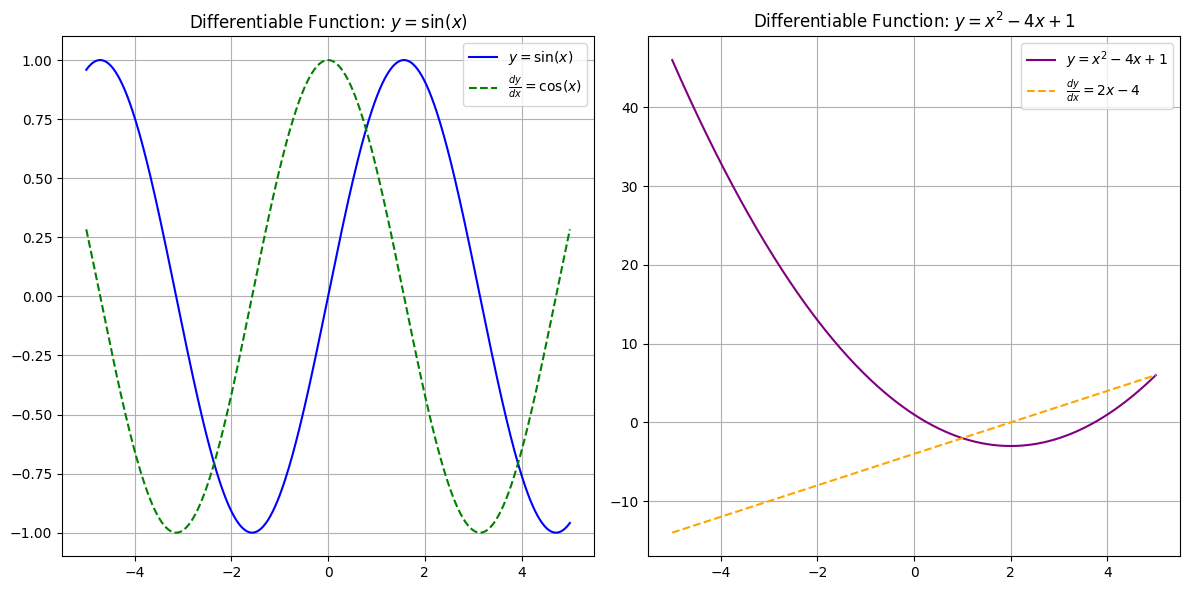

In [364]:
def differentiable_func(x):
    return np.sin(x), np.cos(x)

x_values = np.linspace(-5, 5, 400)
y_diff, dy_diff = differentiable_func(x_values)
y_quad, dy_quad = quadratic_func(x_values)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].plot(x_values, y_diff, label=r'$y = \sin(x)$', color='b')
axes[0].plot(x_values, dy_diff, label=r"$\frac{dy}{dx} = \cos(x)$", color='g', linestyle='dashed')
axes[0].set_title("Differentiable Function: $y = \sin(x)$")
axes[0].legend()
axes[0].grid()

axes[1].plot(x_values, y_quad, label=r'$y = x^2 - 4x + 1$', color='purple')
axes[1].plot(x_values, dy_quad, label=r"$\frac{dy}{dx} = 2x - 4$", color='orange', linestyle='dashed')
axes[1].set_title("Differentiable Function: $y = x^2 - 4x + 1$")
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


Functions that cannot be differentiated

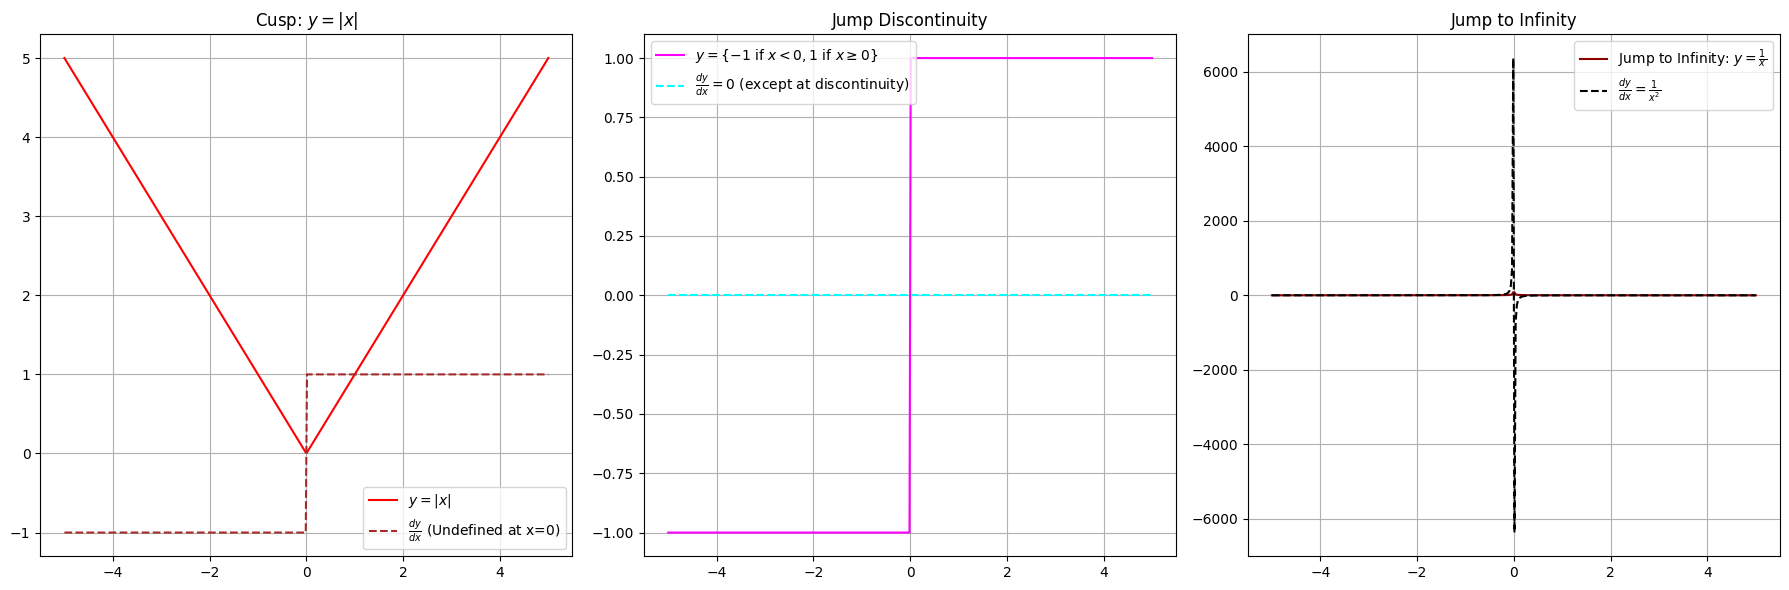

In [365]:
def non_differentiable_func(x):
    return np.abs(x), np.piecewise(x_values, [x_values < 0, x_values > 0], [-1, 1])

def jump_discontinuity(x):
    return np.piecewise(x, [x < 0, x >= 0], [-1, 1]), np.zeros_like(x_values)

def jump_to_infinity(x):
    return np.piecewise(x, [x < 0, x >= 0], [lambda x: -1/x, lambda x: 1/x]), np.piecewise(x, [x < 0, x > 0], [lambda x: 1/x**2, lambda x: -1/x**2])


x_values_no_zero = np.linspace(-5, 5, 400)
x_values_no_zero[x_values_no_zero == 0] = np.nan

y_non_diff, dy_non_diff = non_differentiable_func(x_values_no_zero)
y_jump, dy_jump = jump_discontinuity(x_values_no_zero)
y_inf_jump, dy_inf_jump = jump_to_infinity(x_values_no_zero)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].plot(x_values, y_non_diff, label=r'$y = |x|$', color='r')
axes[0].plot(x_values, dy_non_diff, label=r"$\frac{dy}{dx}$ (Undefined at x=0)", color='brown', linestyle='dashed')
axes[0].set_title("Cusp: $y = |x|$")
axes[0].legend()
axes[0].grid()

axes[1].plot(x_values_no_zero, y_jump, label=r'$y = \{-1 \text{ if } x < 0, 1 \text{ if } x \geq 0\}$', color='magenta')
axes[1].plot(x_values_no_zero, dy_jump, label=r"$\frac{dy}{dx} = 0$ (except at discontinuity)", color='cyan', linestyle='dashed')
axes[1].set_title("Jump Discontinuity")
axes[1].legend()
axes[1].grid()

axes[2].plot(x_values_no_zero, y_inf_jump, label=r'Jump to Infinity: $y = \frac{1}{x}$', color='darkred')
axes[2].plot(x_values_no_zero, dy_inf_jump, label=r"$\frac{dy}{dx} = \frac{1}{x^2}$", color='black', linestyle='dashed')
axes[2].set_title("Jump to Infinity")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()

## Gradient Descent Implementation

1. **Initialize** \( x \) at a starting point.
2. **Compute the gradient** of the function at the current \( x \).
3. **Update \( x \)** by stepping in the negative direction of the gradient.
4. **Repeat until convergence**, determined by a small change in \( x \).

The update rule follows:

$$
x_{t+1} = x_t - \eta \cdot \nabla f(x_t)
$$

where:
- $ x_t $ is the current value of $ x $,
- $ \eta $ is the **learning rate**,
- $ \nabla f(x_t) $ is the gradient of the function.


  0%|          | 0/100 [00:00<?, ?it/s]

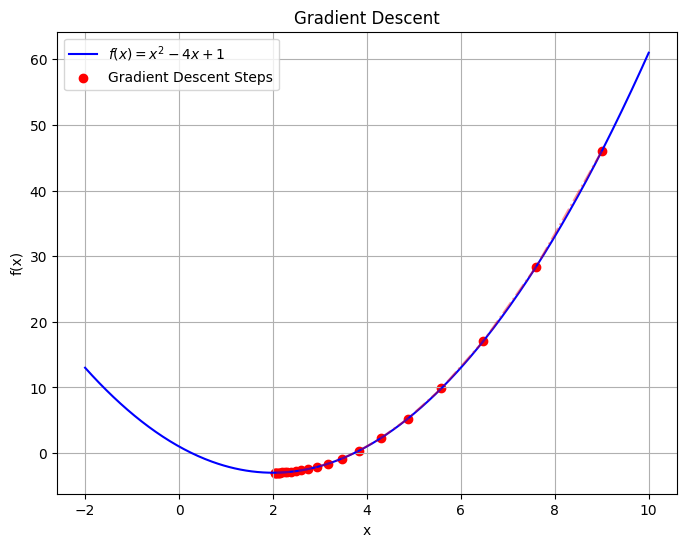

[9,
 7.6,
 6.4799999999999995,
 5.584,
 4.8671999999999995,
 4.29376,
 3.8350079999999998,
 3.4680063999999997,
 3.17440512,
 2.939524096,
 2.7516192768,
 2.60129542144,
 2.481036337152,
 2.3848290697216,
 2.30786325577728,
 2.246290604621824,
 2.197032483697459,
 2.1576259869579673,
 2.1261007895663737,
 2.100880631653099,
 2.080704505322479,
 2.064563604257983,
 2.0516508834063862,
 2.041320706725109]

In [366]:
def gradient_descent(start, gradient, learn_rate, max_iter, tol=0.01):
    x = start
    steps = [start]

    for _ in tqdm(range(max_iter)):
        diff = learn_rate * gradient(x)
        if abs(diff) < tol:
            break
        x -= diff
        steps.append(x)

    return steps, x

def gradient_func(x):
    _, dx = quadratic_func(x)
    return dx

x_values = np.linspace(-2, 10, 400)
y_values, _  = quadratic_func(x_values)

history, result = gradient_descent(9, gradient_func, 0.1, 100)

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=r'$f(x) = x^2 - 4x + 1$', color='b')

y_history = [quadratic_func(x)[0] for x in history]
plt.plot(history, y_history, color='r', alpha=0.4, linestyle="-.")
plt.scatter(history, y_history, color='r', label='Gradient Descent Steps')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gradient Descent')
plt.legend()
plt.grid()
plt.show()

history

Various learning rates

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

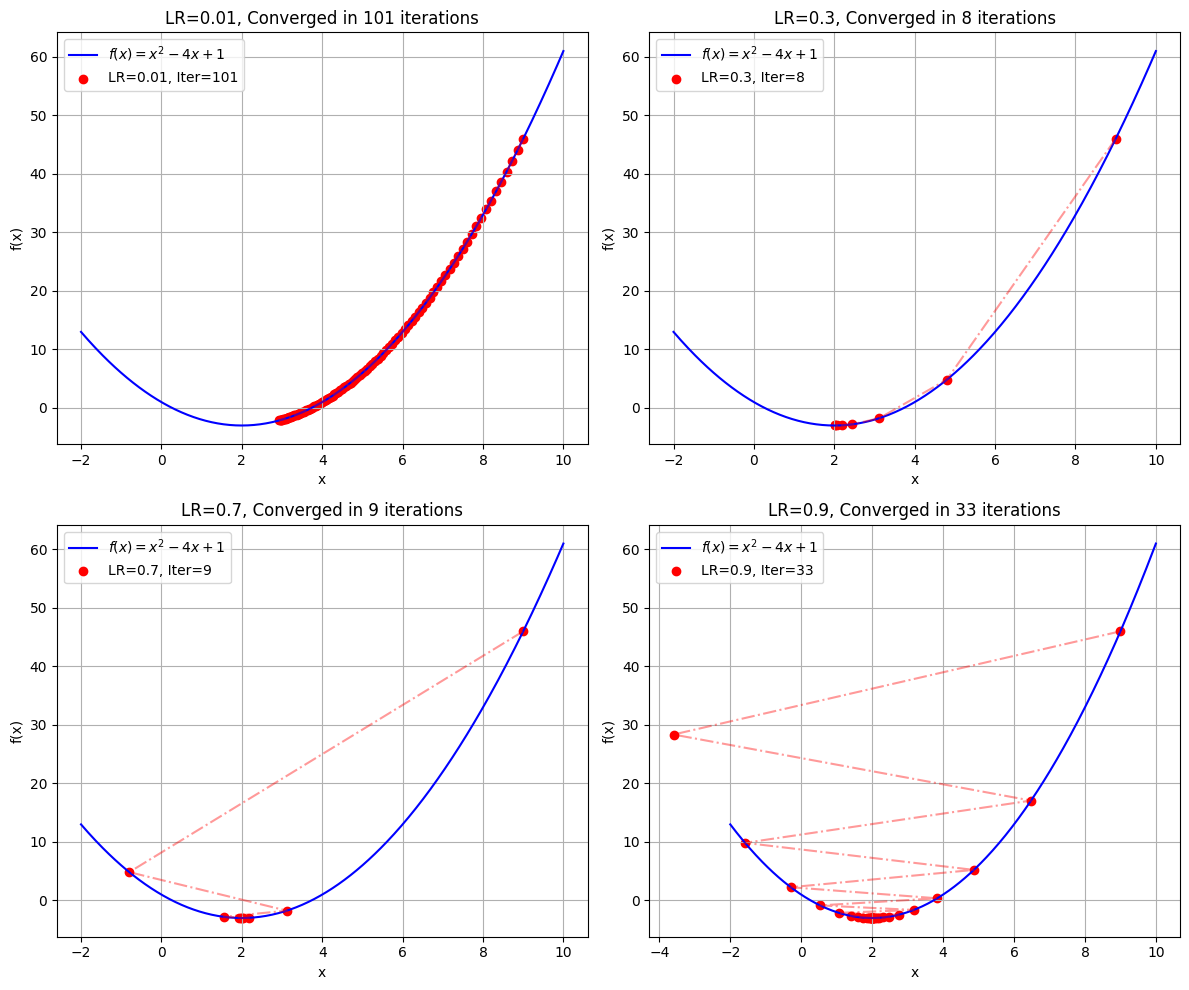

In [367]:
learning_rates = [0.01, 0.3, 0.7, 0.9]
fig, axes = plt.subplots(len(learning_rates)//2, len(learning_rates)//2, figsize=(12, 10))

for ax, lr in zip(axes.flatten(), learning_rates):
    history, result = gradient_descent(9, gradient_func, lr, 100)
    y_history = [quadratic_func(x)[0] for x in history]

    ax.plot(x_values, y_values, color='b', label=r'$f(x) = x^2 - 4x + 1$')
    ax.plot(history, y_history, color='r', alpha=0.4, linestyle="-.")
    ax.scatter(history, y_history, color='r', label=f'LR={lr}, Iter={len(history)}')

    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(f'LR={lr}, Converged in {len(history)} iterations')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Matrix Form

Matrices are computationally efficient, best to get confident with them.

To set a threshold, we measure the norm of the gradient's vector.
In **linear algebra**, the **norm** of a vector is a measure of its magnitude (length). This is a step size. The L2 norm (Euclidean norm), is calculated as:

$
\|\mathbf{v}\|_2 = \sqrt{v_1^2 + v_2^2 + \dots + v_n^2}
$

In later GD algos, we don't use tolerance as we iterate through the batches. In ML there is the concept of early stopping, there yes tolerance or (patience) is used again.

In [368]:
def gradient_descent_matrix(start, gradient, learn_rate, max_iter, tol=0.001):
    x = np.array(start, dtype=np.float64).reshape(-1, 1)
    steps = [x.copy()]

    for _ in tqdm(range(max_iter)):
        diff = learn_rate * gradient(x)
        if np.linalg.norm(diff) < tol:
            break
        x -= diff
        steps.append(x.copy())

    return np.hstack(steps), x

def quadratic_func_matrix(X):
    return np.sum(X**2, axis=0) - 4*np.sum(X, axis=0) + 1, 2*X - 4

def gradient_func_matrix(X):
    _, dx = quadratic_func_matrix(X)
    return dx

history, result = gradient_descent_matrix([[9], [7]], gradient_func_matrix, 0.1, 100)
history, result

  0%|          | 0/100 [00:00<?, ?it/s]

(array([[9.        , 7.6       , 6.48      , 5.584     , 4.8672    ,
         4.29376   , 3.835008  , 3.4680064 , 3.17440512, 2.9395241 ,
         2.75161928, 2.60129542, 2.48103634, 2.38482907, 2.30786326,
         2.2462906 , 2.19703248, 2.15762599, 2.12610079, 2.10088063,
         2.08070451, 2.0645636 , 2.05165088, 2.04132071, 2.03305657,
         2.02644525, 2.0211562 , 2.01692496, 2.01353997, 2.01083198,
         2.00866558, 2.00693246, 2.00554597, 2.00443678, 2.00354942],
        [7.        , 6.        , 5.2       , 4.56      , 4.048     ,
         3.6384    , 3.31072   , 3.048576  , 2.8388608 , 2.67108864,
         2.53687091, 2.42949673, 2.34359738, 2.27487791, 2.21990233,
         2.17592186, 2.14073749, 2.11258999, 2.09007199, 2.07205759,
         2.05764608, 2.04611686, 2.03689349, 2.02951479, 2.02361183,
         2.01888947, 2.01511157, 2.01208926, 2.00967141, 2.00773713,
         2.0061897 , 2.00495176, 2.00396141, 2.00316913, 2.0025353 ]]),
 array([[2.00354942],
        

Plot it on a 3D surface.

In [369]:
import plotly.graph_objects as go

x_values = np.linspace(-2, 10, 100)
y_values = np.linspace(-2, 10, 100)
X, Y = np.meshgrid(x_values, y_values)
Z, _ = quadratic_func_matrix(np.array([X, Y]))

history_x = history[0, :]
history_y = history[1, :]
history_z = quadratic_func_matrix(np.array([history_x, history_y]))[0]

fig = go.Figure()
fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.8))
fig.add_trace(go.Scatter3d(
    x=history_x, y=history_y, z=history_z,
    mode='markers+lines',
    marker=dict(size=5, color='red', opacity=0.8),
    line=dict(width=3, dash='dash', color='red'),
    name="Gradient Descent Path"
))
fig.update_layout(
    title="Gradient Descent on Quadratic Function",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='f(X, Y)'
    ),
    width=800,
    height=800,
    showlegend=True
)
fig.show()

## Implementing on Convex

We test gradient descent on a function with a saddle point.

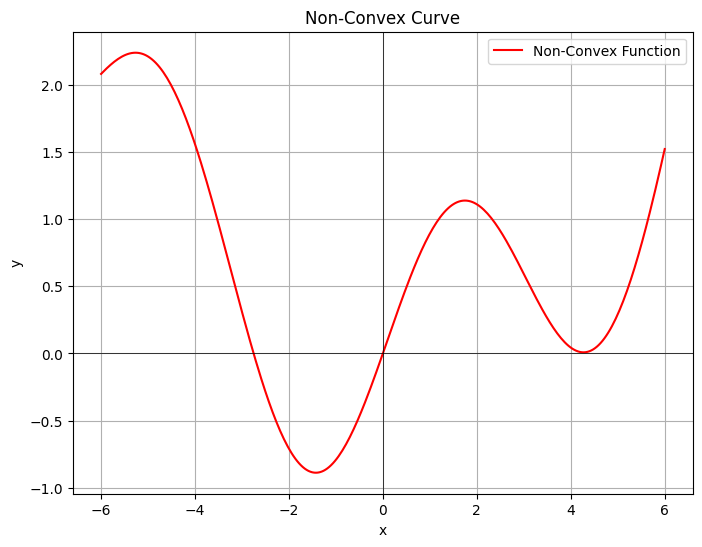

In [370]:
def non_convex_function(x):
    return np.sin(x) + 0.05 * x**2, np.cos(x) + 0.1 * x

x_values = np.linspace(-6, 6, 300)
y_values, _ = non_convex_function(x_values)

plt.figure(figsize=(8, 6))
plt.plot(x_values, y_values, label=r'Non-Convex Function', color='r')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Non-Convex Curve')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

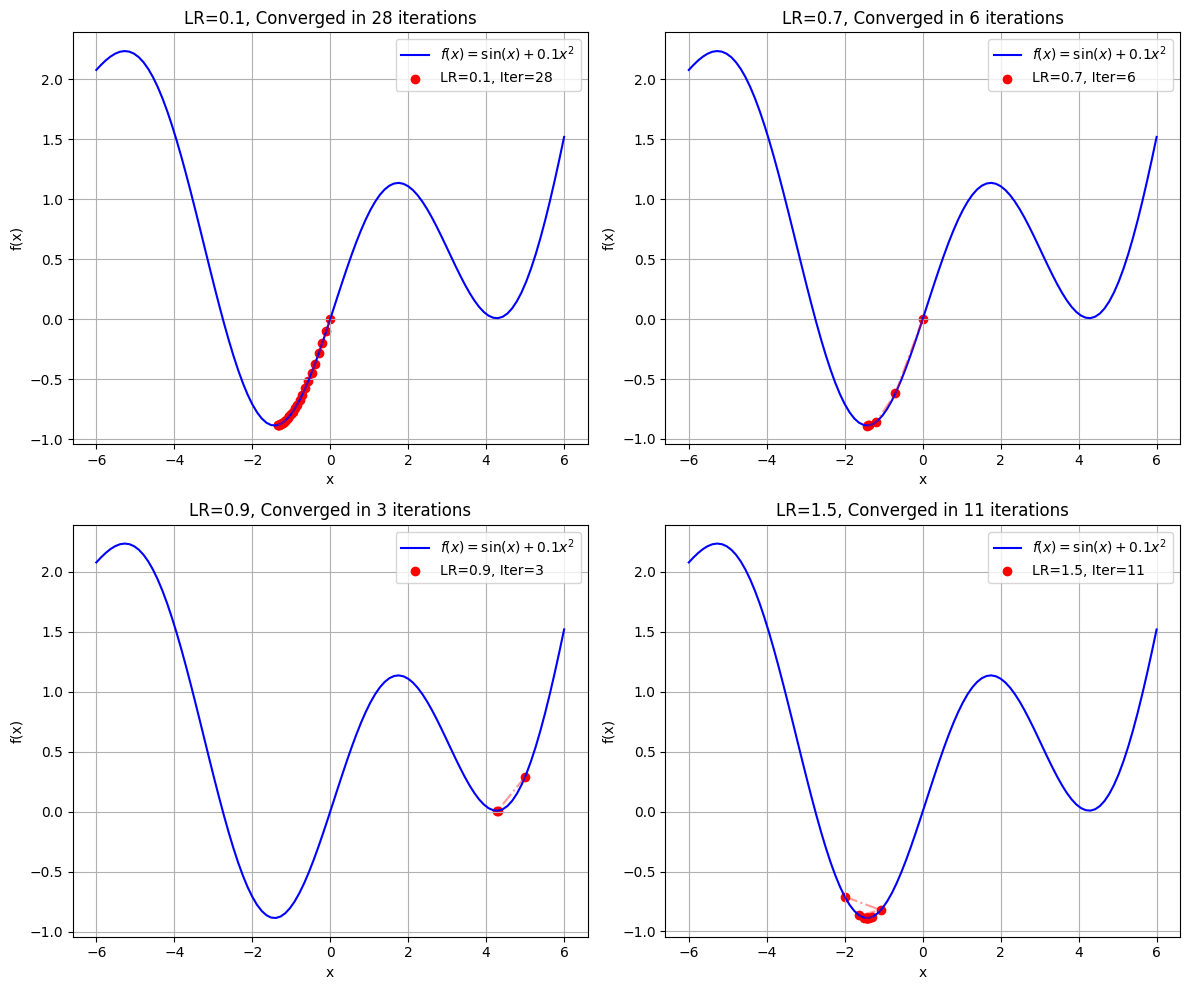

In [371]:
import random

learning_rates = [0.1, 0.7, 0.9, 1.5]
fig, axes = plt.subplots(len(learning_rates) // 2, len(learning_rates) // 2, figsize=(12, 10))
x_values = np.linspace(-6, 6, 100)
y_values, _ = non_convex_function(x_values)

def gradient_func_non_convex(X):
    _, dx = non_convex_function(X)
    return dx

for ax, lr in zip(axes.flatten(), learning_rates):
    history, result = gradient_descent(int(np.random.rand() * 12 - 6), gradient_func_non_convex, lr, 100)

    y_history = [non_convex_function(x)[0] for x in history]

    ax.plot(x_values, y_values, color='b', label=r'$f(x) = \sin(x) + 0.1x^2$')
    ax.plot(history, y_history, color='r', alpha=0.4, linestyle="-.")
    ax.scatter(history, y_history, color='r', label=f'LR={lr}, Iter={len(history)}')

    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(f'LR={lr}, Converged in {len(history)} iterations')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

### Matrix Form

From here onwards we will only work with matrices.

In [372]:
def non_convex_function_matrix(X):
    return np.sum(np.sin(X) + 0.05 * X**2, axis=0), np.cos(X) + 0.1 * X

def gradient_func_non_convex(X):
    _, dx = non_convex_function_matrix(X)
    return dx

history_non_convex, result_non_convex = gradient_descent_matrix([[9], [7]], gradient_func_non_convex, 0.01, 100)
history_non_convex, result_non_convex

  0%|          | 0/100 [00:00<?, ?it/s]

(array([[9.        , 9.0001113 , 9.00022295, 9.00033495, 9.0004473 ,
         9.00056   , 9.00067305, 9.00078645, 9.0009002 , 9.00101431,
         9.00112877, 9.00124359, 9.00135877, 9.00147431, 9.0015902 ,
         9.00170645, 9.00182307, 9.00194005, 9.00205739, 9.00217509,
         9.00229316, 9.0024116 , 9.0025304 , 9.00264957, 9.00276911,
         9.00288902, 9.00300931, 9.00312996, 9.00325099, 9.00337239,
         9.00349417, 9.00361632, 9.00373885, 9.00386176, 9.00398504,
         9.00410871, 9.00423276, 9.00435719, 9.00448201, 9.00460721,
         9.0047328 , 9.00485877, 9.00498513, 9.00511188, 9.00523902,
         9.00536655, 9.00549447, 9.00562278, 9.00575149, 9.00588059,
         9.00601009, 9.00613999, 9.00627028, 9.00640098, 9.00653207,
         9.00666357, 9.00679547, 9.00692777, 9.00706047, 9.00719359,
         9.00732711, 9.00746103, 9.00759537, 9.00773012, 9.00786527,
         9.00800084, 9.00813682, 9.00827322, 9.00841003, 9.00854726,
         9.00868491, 9.00882298, 9

### Plot the Descent

The function below will create a 3D visualization of the descent.

3D means 3 features.

In [373]:
import plotly.graph_objects as go

def plot_gradient_descent(history_x, history_y, function_matrix):
    history_x = np.array(history_x)
    history_y = np.array(history_y)
    history_z, _ = function_matrix(np.array([history_x, history_y]))

    start_x, start_y, start_z = history_x[0], history_y[0], history_z[0]
    end_x, end_y, end_z = history_x[-1], history_y[-1], history_z[-1]
    x_min, x_max = history_x.min(), history_x.max()
    y_min, y_max = history_y.min(), history_y.max()
    z_min, z_max = history_z.min(), history_z.max()

    x_margin = 0.05 * (x_max - x_min)
    y_margin = 0.05 * (y_max - y_min)
    z_margin = 0.05 * (z_max - z_min)

    x_range = (x_min - x_margin, x_max + x_margin)
    y_range = (y_min - y_margin, y_max + y_margin)
    z_range = (z_min - z_margin, z_max + z_margin)

    x_values = np.linspace(*x_range, 100)
    y_values = np.linspace(*y_range, 100)
    X, Y = np.meshgrid(x_values, y_values)
    Z, _ = function_matrix(np.array([X, Y]))

    fig = go.Figure()
    fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.6))
    fig.add_trace(go.Scatter3d(
        x=history_x, y=history_y, z=history_z,
        mode='markers+lines',
        marker=dict(size=5, color='red', opacity=0.8),
        line=dict(width=3, dash='dash', color='red'),
        name="Path"
    ))
    fig.add_trace(go.Scatter3d(
        x=[start_x], y=[start_y], z=[start_z],
        mode='markers',
        marker=dict(size=12, color='lime', symbol='diamond', opacity=1),
        name="Start"
    ))
    fig.add_trace(go.Scatter3d(
        x=[end_x], y=[end_y], z=[end_z],
        mode='markers',
        marker=dict(size=12, color='blue', symbol='cross', opacity=1),
        name="End"
    ))

    fig.update_layout(
        title="Gradient Descent",
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='f(X, Y)',
            xaxis=dict(range=x_range),
            yaxis=dict(range=y_range),
            zaxis=dict(range=z_range)
        ),
        width=800,
        height=800,
        showlegend=True
    )

    fig.show()

plot_gradient_descent(history_x, history_y, non_convex_function_matrix)

# Types of Gradient Descent

## Batch Gradient Descent (BGD)

Batch Gradient Descent is the most basic form of gradient descent. It updates the model parameters using the gradient computed over the entire dataset at every iteration.


Everything you did before this section is the batch variant. In fact, we will use the matrix GD, but taking a batch of vectors and we return the average gradient.


Pros and Cons:
1. Uses the entire dataset to compute the gradient.
1. More stable than stochastic gradient descent.
1. Slower for large datasets because each update requires computing the full gradient.
1. Converges smoothly but can get stuck in local minima in non-convex functions

  0%|          | 0/100 [00:00<?, ?it/s]

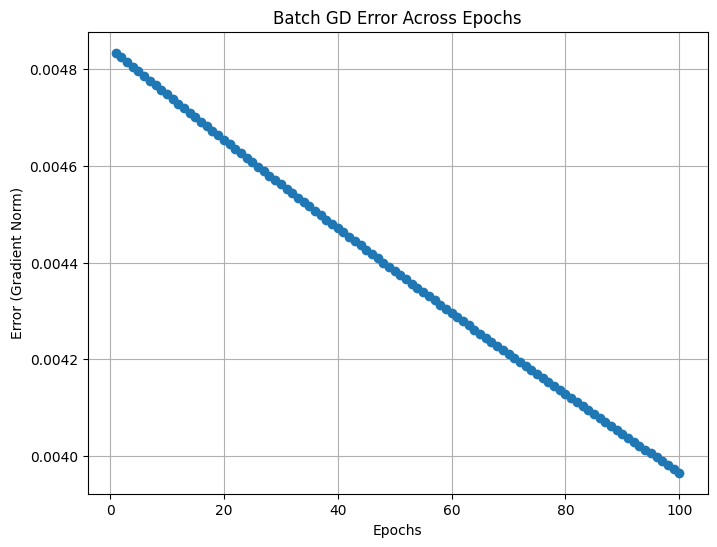

Dim-1     Dim-2
0     4.154455  0.848427
1    -0.948553 -8.374724
2     1.737860 -7.175379
3     7.334653 -7.408159
4    -8.850099  4.393673
...        ...       ...
2015 -3.012891  9.481569
2016  3.379407  6.016839
2017  9.851304  4.459827
2018 -2.391362 -2.301095
2019 -4.936443 -8.094420

[2020 rows x 2 columns]

In [374]:
def batch_gradient_descent(start, gradient, learn_rate, epochs):
    x = np.array(start, dtype=np.float64)
    steps = [x.copy()]
    errors = []
    for _ in tqdm(range(epochs)):
        diff = learn_rate * gradient(x).mean(axis=1, keepdims=True)
        x -= diff
        steps.append(x.copy())
        errors.append(np.linalg.norm(diff))

    return np.hstack(steps), x, errors

start_points = np.random.uniform(low=-10, high=10, size=(2, 20))
history_bgd, result_bgd, error_bgd = batch_gradient_descent(start_points,
                                                            gradient_func_matrix,
                                                            learn_rate=0.001,
                                                            epochs=100)


df_history_bgd = pd.DataFrame(history_bgd.T, columns=[f"Dim-{i+1}" for i in range(history_bgd.shape[0])])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(error_bgd) + 1), error_bgd, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Error (Gradient Norm)")
plt.title("Batch GD Error Across Epochs")
plt.grid()
plt.show()

df_history_bgd

In [375]:
history_x = history_bgd[0, :]
history_y = history_bgd[1, :]
plot_gradient_descent(history_x, history_y, non_convex_function_matrix)

## Stochastic Gradient Descent (SGD)

Stochastic Gradient Descent (SGD) is a variant of gradient descent where, instead of computing the gradient over the entire dataset (Batch GD), it updates the model parameters using only one randomly chosen data point per iteration.

In our version, we implement the 'online' version, where we shuffle the Dataset instead of picking a random point, ensuring there is no replacement.

Pros and Cons of SGD
1. Faster for large datasets because it updates parameters after each sample, rather than waiting for the full batch.
1. Can escape local minima because the noisy updates prevent getting stuck in suboptimal points.
1. More memory-efficient since it doesn't require the entire dataset at once.

1. High variance in updates, meaning it may fluctuate rather than converge smoothly.
1. May not settle at the exact minimum since updates are more erratic.
1. Requires tuning the learning rate carefully, as large step sizes can lead to divergence.

  0%|          | 0/300 [00:00<?, ?it/s]

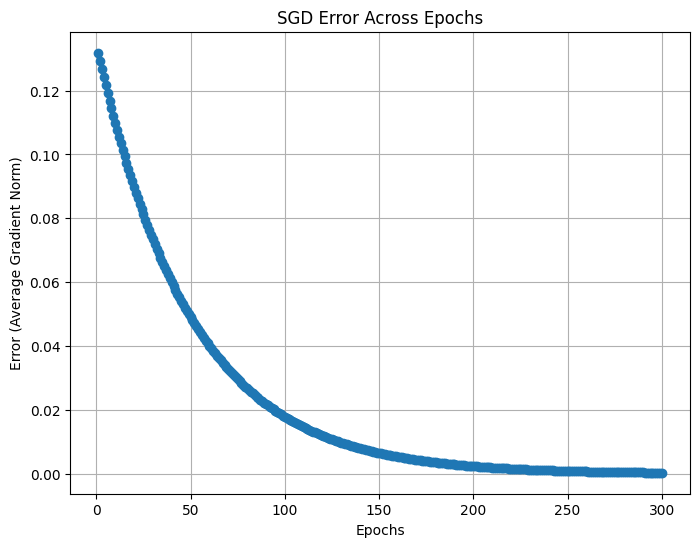

Dim-1     Dim-2
0     7.537811  2.361525
1     5.107104  9.666052
2     3.841224  3.581520
3     1.657455 -7.853820
4     0.057848  5.470824
...        ...       ...
6015  2.004553  1.988775
6016  2.002013  2.002867
6017  1.976345  2.015254
6018  2.000248  2.010460
6019  1.980701  2.013437

[6020 rows x 2 columns]

In [376]:

def stochastic_gradient_descent(start, gradient, learn_rate, epochs):
    x = np.array(start, dtype=np.float64)
    steps = [x.copy()]
    errors = []

    for _ in tqdm(range(epochs)):
        error = 0
        indices = np.arange(x.shape[1])
        np.random.shuffle(indices)

        for random_index in indices:
            x_sample = x[:, random_index].reshape(-1, 1)
            diff = learn_rate * gradient(x_sample)

            x[:, random_index] -= diff.flatten()
            error += np.linalg.norm(diff)

        steps.append(x.copy())
        errors.append(error / len(indices))

    return np.hstack(steps), x, errors


start_points = np.random.uniform(low=-10, high=10, size=(2, 20))
history_sgd, result_sgd, error_sgd = stochastic_gradient_descent(start_points,
                                                                 gradient_func_matrix,
                                                                 learn_rate=0.01,
                                                                 epochs=300)


df_history_sgd = pd.DataFrame(history_sgd.T, columns=[f"Dim-{i+1}" for i in range(history_sgd.shape[0])])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(error_sgd) + 1), error_sgd, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Error (Average Gradient Norm)")
plt.title("SGD Error Across Epochs")
plt.grid()
plt.show()

df_history_sgd


In [377]:
history_x = history_sgd[0, :]
history_y = history_sgd[1, :]
plot_gradient_descent(history_x, history_y, non_convex_function_matrix)

## Mini-Batch Gradient Descent (MBGD)

Mini-Batch Gradient Descent (MBGD) is a compromise between **Batch GD** and **Stochastic GD**, where the gradient is computed using a small subset (mini-batch).

1. Faster convergence than Batch GD, as it updates parameters more frequently.
1. Reduces variance compared to SGD, leading to a more stable convergence.
1. More computationally efficient than full Batch GD, making it scalable for large datasets.

1. Still has some variance, meaning updates are noisier than Batch GD.
1. Requires tuning batch size, as too small a batch makes it behave like SGD, and too large makes it behave like Batch GD.
1. May still get stuck in local minima, especially in non-convex optimization.


  0%|          | 0/1000 [00:00<?, ?it/s]

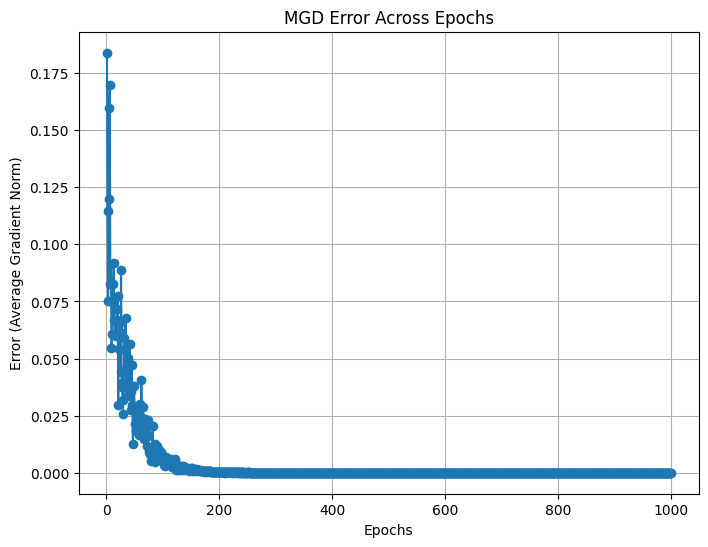

Dim-1     Dim-2
0     -0.032345  2.310933
1     -4.224767  5.225821
2     -3.552999  5.717341
3     -5.532376 -1.909965
4     -3.187552 -4.912434
...         ...       ...
20015  2.000000  2.000000
20016  2.000000  2.000000
20017  2.000000  2.000000
20018  2.000000  2.000000
20019  2.000000  2.000000

[20020 rows x 2 columns]

In [378]:
def mini_batch_gradient_descent(start, gradient, learn_rate, epochs, batch_size=10):
    x = np.array(start, dtype=np.float64)
    steps = [x.copy()]
    errors = []

    for _ in tqdm(range(epochs)):
        error = 0
        indices = np.arange(x.shape[1])
        np.random.shuffle(indices)

        for i in range(0, len(indices), batch_size):
            batch_indices = indices[i:i + batch_size]
            x_batch = x[:, batch_indices]
            diff = learn_rate * gradient(x_batch).mean(axis=1, keepdims=True)
            x[:, batch_indices] -= diff
            error += np.linalg.norm(diff)

        steps.append(x.copy())
        errors.append(error / len(indices))

    return np.hstack(steps), x, errors

start_points = np.random.uniform(low=-10, high=10, size=(2, 20))
history_mbgd, result_mbgd, error_mbgd = mini_batch_gradient_descent(start_points,
                                                                    gradient_func_matrix,
                                                                    learn_rate=0.1,
                                                                    epochs=1000,
                                                                    batch_size=5)

df_history_mbgd = pd.DataFrame(history_mbgd.T, columns=[f"Dim-{i+1}" for i in range(history_mbgd.shape[0])])

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(error_mbgd) + 1), error_mbgd, marker='o', linestyle='-')
plt.xlabel("Epochs")
plt.ylabel("Error (Average Gradient Norm)")
plt.title("MGD Error Across Epochs")
plt.grid()
plt.show()

df_history_mbgd

In [379]:
history_x = history_mbgd[0, :]
history_y = history_mbgd[1, :]
plot_gradient_descent(history_x, history_y, non_convex_function_matrix)

# Minimize Error

Using the breast cancer dataset, we will run the gradient descents to minimize the BCE error.

Most of the code is taken from the Logistic Regression Notebook.

In [380]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

breast_cancer = load_breast_cancer(as_frame=True)
breast_cancer_df = breast_cancer.frame

X = breast_cancer_df.drop('target', axis=1).values
y = breast_cancer.target.values.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_bias = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_bias = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

breast_cancer_df.sample(3)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
295        13.77         13.27           88.06      582.7          0.09198   
521        24.63         21.60          165.50     1841.0          0.10300   
451        19.59         25.00          127.70     1191.0          0.10320   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
295           0.06221         0.01063              0.01917         0.1592   
521           0.21060         0.23100              0.14710         0.1991   
451           0.09871         0.16550              0.09063         0.1663   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
295                 0.05912  ...          16.93            94.17       661.1   
521                 0.06739  ...          26.93           205.70      2642.0   
451                 0.05391  ...          30.96           139.80      1421.0   

     worst smoothness  worst compactness  worst concavity  \
295            0.1170             0.1072          0.03732   
521            0.1342             0.4188          0.46580   
451            0.1528             0.1845          0.39770   

     worst concave points  worst symmetry  worst fractal dimension  target  
295               0.05802          0.2823                  0.06794       1  
521               0.24750          0.3157                  0.09671       0  
451               0.14660          0.2293                  0.06091       0  

[3 rows x 31 columns]

  0%|          | 0/100 [00:00<?, ?it/s]

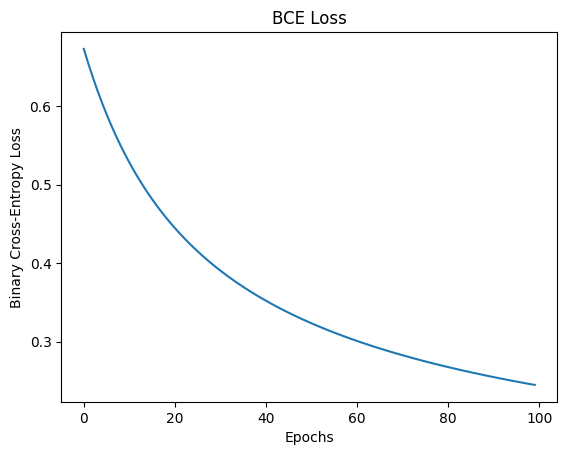

In [381]:
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-10
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

def compute_gradient(weights, x, y):
    predictions = sigmoid(x @ weights)
    error = predictions - y
    return (x.T @ error) / x.shape[0]

def compute_bce(weights, x, y):
    predictions = sigmoid(x @ weights)
    return binary_cross_entropy(y, predictions)

def fullbatch_gradient_descent(betas, x, y, gradient, compute_loss, learn_rate, epochs):
    betas = np.array(betas, dtype=np.float64)
    steps = [betas.copy()]
    losses = []
    for _ in tqdm(range(epochs)):
        diff = learn_rate * gradient(betas, x, y)
        betas -= diff
        steps.append(betas.copy())
        losses.append(compute_loss(betas, x, y))

    return np.hstack(steps), betas, losses

start_weights = np.zeros((X_train_bias.shape[1], 1))
history, weights, loss_history = fullbatch_gradient_descent(
    start_weights,
    X_train_bias,
    y_train,
    compute_gradient,
    compute_bce,
    learn_rate=0.01,
    epochs=100
)

plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("BCE Loss")
plt.show()

what's our score?

In [382]:
from sklearn.metrics import classification_report

y_test_pred_prob = sigmoid(X_test_bias @ weights)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



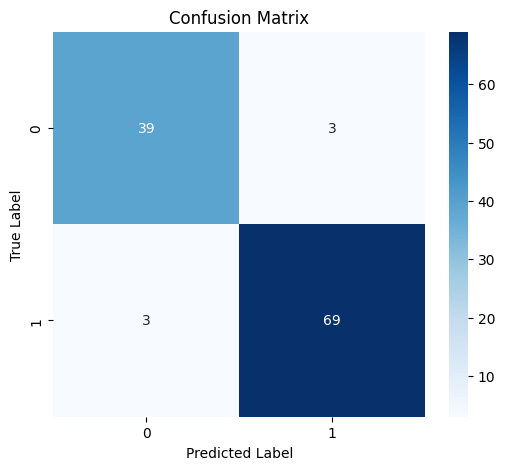

In [383]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

test_cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.show()

Using SGD.

  0%|          | 0/100 [00:00<?, ?it/s]

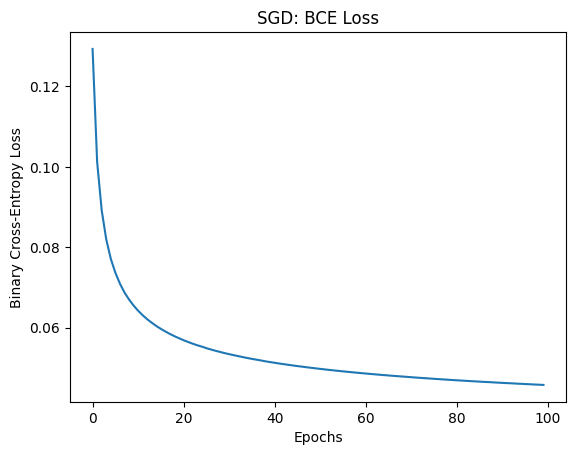

In [384]:
def stochastic_gradient_descent(betas, x, y, gradient, compute_loss, learn_rate, epochs):
    betas = np.array(betas, dtype=np.float64)
    steps = [betas.copy()]
    losses = []

    num_samples = x.shape[0]

    for _ in tqdm(range(epochs)):
        error = 0
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        for i in indices:
            x_sample = x[i, :].reshape(1, -1)
            y_sample = y[i].reshape(-1, 1)

            diff = learn_rate * gradient(betas, x_sample, y_sample)
            betas -= diff
            error += np.linalg.norm(diff)

        steps.append(betas.copy())
        losses.append(compute_loss(betas, x, y))

    return np.hstack(steps), betas, losses

start_weights = np.zeros((X_train_bias.shape[1], 1))
history_sgd, weights_sgd, loss_history_sgd = stochastic_gradient_descent(
    start_weights,
    X_train_bias,
    y_train,
    compute_gradient,
    compute_bce,
    learn_rate=0.01,
    epochs=100
)

plt.plot(loss_history_sgd)
plt.xlabel("Epochs")
plt.ylabel("Binary Cross-Entropy Loss")
plt.title("SGD: BCE Loss")
plt.show()

In [385]:
y_test_pred_prob = sigmoid(X_test_bias @ weights)
y_test_pred = (y_test_pred_prob >= 0.5).astype(int)

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93        42
           1       0.96      0.96      0.96        72

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



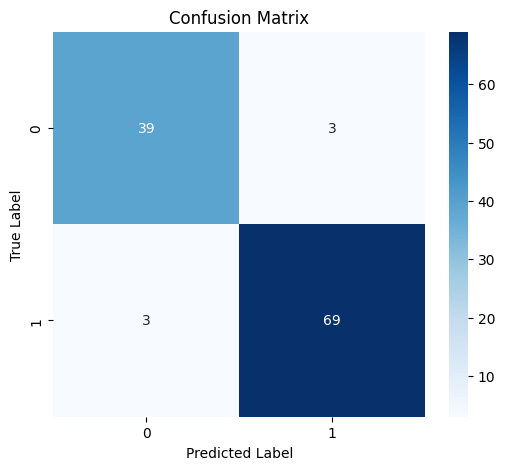

In [386]:
test_cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

sns.heatmap(test_cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

plt.show()

# Conclussion

In this notebook you learned about gradient descent, you have built the alogrithm to minimize a function.

You learned about the 3 major types of GD.

and you applied you algos to the breast cancer dataset.

With that see you in the next one on SVNs!